In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils, layers
from tensorflow.keras.models import Model
import pandas as pd
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod
from gewitter_functions import get_acc



sys.path.insert(1, '/projects/reba1583/Research3/AntarcticAR_ML/')

from define_variables import get_variables,get_variable_names,get_variable_lats
from functions import build_variable_model

2024-05-16 09:50:25.198579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## full model

In [2]:
pd.DataFrame(get_variable_names())

,0
0,H500_lead0
1,H500_lead1
2,H500_lead2
3,U800_lead0
4,V800_lead0
5,SLP_lead0
6,SLP_lead1
7,SLP_lead2
8,EFLUX_lead0
9,EFLUX_lead1


In [3]:
variable_id = [ 5, 0, 14] # 9, 12, 16,
print([get_variable_names()[variable_id[v]] for v in range(len(variable_id))])

testing_num_samples =  14610
train_index = int(np.round(testing_num_samples*.7))
val_index = int(np.round(testing_num_samples*.85))


['SLP_lead0', 'H500_lead0', 'sf_lead0']


In [98]:
# region_select = [9,0,1]
region_select = [0]
Y = pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/AR_binary_daily.csv', index_col = False)
Y_East1 = np.array(Y.loc[Y.index.isin(region_select)].sum())
Y_East1 = np.where(Y_East1>0,1,0)[0:testing_num_samples]


## trim to make AR and no AR equal

In [89]:
train_trim_index = np.sort(np.concatenate((np.where(Y_East1[:train_index]==1)[0], np.where(Y_East1[:train_index]==0)[0][:len(np.where(Y_East1[:train_index]==1)[0])]),axis = 0))
val_trim_index =  np.sort(np.concatenate((np.where(Y_East1[train_index:val_index]==1)[0], np.where(Y_East1[train_index:val_index]==0)[0][:len(np.where(Y_East1[train_index:val_index]==1)[0])]),axis = 0))




In [90]:
    

variable_data = []
variable_names = []
for v in range(len(variable_id)):
    variable_names.append(get_variables()[variable_id[v]])
    data = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Daily_data_neuraladd/'+(get_variable_names()[variable_id[v]])+'*').isel(time = slice(0,testing_num_samples))[variable_names[v]]
    if 'lev' in data.dims:
        data = data.squeeze()
        data = data.drop('lev')
    variable_data.append(data)



In [91]:
# ### yes trimming to balance
# # get climo and std based on all training data
# train_climo = [variable_data[m].isel(time = slice(0, train_index)).groupby("time.month").mean('time',skipna=True).load() for m in range(len(variable_data))]
# train_std = [variable_data[m].isel(time = slice(0, train_index)).groupby("time.month").std('time',skipna=True).load() for m in range(len(variable_data))]


# train_X_notanom = [variable_data[m].isel(time = slice(0, train_index)).isel(time = train_trim_index).load() for m in range(len(variable_data))]

# train_Y = Y_East1[:train_index][train_trim_index]
# val_X_notanom = [variable_data[m].isel(time = slice(train_index, val_index)).load() for m in range(len(variable_data))]
# val_Y = Y_East1[train_index:val_index]


### no trimming 
train_climo = [variable_data[m].isel(time = slice(0, train_index)).groupby("time.month").mean('time',skipna=True).load() for m in range(len(variable_data))]
train_std = [variable_data[m].isel(time = slice(0, train_index)).groupby("time.month").std('time',skipna=True).load() for m in range(len(variable_data))]


train_X_notanom = [variable_data[m].isel(time = slice(0, train_index)).load() for m in range(len(variable_data))]

train_Y = Y_East1[:train_index] 
val_X_notanom = [variable_data[m].isel(time = slice(train_index, val_index)).load() for m in range(len(variable_data))]
val_Y = Y_East1[train_index:val_index]


In [99]:
# Make std anomalies based on the climo from only the training data
train_X = [xr.apply_ufunc(
    lambda x, c, s: (x - c) / s,
    train_X_notanom[m].groupby("time.month"),
    train_climo[m],
    train_std[m],
) for m in range(len(variable_data))]


val_X = [xr.apply_ufunc(
    lambda x, c, s: (x - c) / s,
    val_X_notanom[m].groupby("time.month"),
    train_climo[m],
    train_std[m],
) for m in range(len(variable_data))]

train_X = [train_X[m].values for m in range(len(variable_data))]
val_X = [val_X[m].values for m in range(len(variable_data))]

In [101]:
weight_for_0 = (1/len(np.where(Y_East1[:train_index] == 0)[0]))*(len(Y_East1[:train_index])/2)
weight_for_1 = (1/len(np.where(Y_East1[:train_index] == 1)[0]))*(len(Y_East1[:train_index])/2)
CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}
CLASS_WEIGHT

{0: 0.5293478260869565, 1: 9.018518518518517}

In [102]:
def built_variable_model(seed,dropout_rate,convolutions, hiddens,input_shape,name):
    conv_layers = len(convolutions)
    dense_layers = len(hiddens)
    
    inputs = tf.keras.Input(shape=input_shape)
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(50, (3, 3), padding='valid', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.01),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2, padding="valid"), 
                
        tf.keras.layers.Conv2D(1, (3, 3), padding='valid'),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.01),
#         tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2, padding="valid"),  
        
        tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(1,activation='sigmoid')
    ], name = name)



    return(model, inputs)

In [103]:
# def built_variable_model(seed,dropout_rate,convolutions, hiddens,input_shape,name):
#     conv_layers = len(convolutions)
#     dense_layers = len(hiddens)
    
#     inputs = tf.keras.Input(shape=(19, 144, 1))

#     x = layers.Conv2D(convolutions[0], (3, 3), padding='valid', activation = layers.LeakyReLU(alpha=0.01))(inputs)
#     x = layers.MaxPooling2D(pool_size=(2, 2), strides = 2, padding="valid")(x), 
    
# #     for i in range(conv_layers-1):
# #         x = layers.Conv2D(convolutions[i+1], (3, 3), padding='valid', activation = layers.LeakyReLU(alpha=0.01))(x)
# #         x = layers.MaxPooling2D(pool_size=(2, 2), strides = 2, padding="valid")(x), 

# #     x = layers.Conv2D(1, (3, 3), padding='valid', activation = layers.LeakyReLU(alpha=0.01))(x),
# #     x = layers.MaxPooling2D(pool_size=(2, 2), strides = 2, padding="valid")(x), 

    
#     x = layers.Flatten(data_format = "channels_first")(x),
    
    
# #     for i in range(dense_layers-1):
# #         x = layers.Dense(hiddens[i], activation='relu')(x),

# #     x = layers.Dense(1,activation='sigmoid')(x)
#     model = Model(inputs=inputs,outputs=x)

#     return(model, inputs)


def combine(seed, modelname):
    inputlayers = [layers.Input(1) for m in range(len(modelname))]
    concatlayer = layers.Concatenate()(inputlayers)
    
    dense = layers.Dense(1,activation='linear')(concatlayer)
    final = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=inputlayers,outputs=final)
    
    return model


def fullmodel(models, inputs, modelname, seed):
    ind_outputs = [models[i](inputs[i]) for i in range(len(inputs))]
    
    combine_output = combine(seed, modelname)(ind_outputs)
    
    model = Model(inputs = inputs, outputs = combine_output)
    
    return model

In [104]:
# example parameters
SEED = [v+1 for  v in range(len(variable_id))]
DROPOUT_RATE = [.4 for  v in range(len(variable_id))]
MODELNAME = [get_variable_names()[variable_id[v]] for v in range(len(variable_id))]
CONVOLUTIONS = [[20] for  v in range(len(variable_id))] 
HIDDENS = [[64] for  v in range(len(variable_id))]
INPUT_SHAPE = [variable_data[v].shape[1:]+(1,) for v in range(len(variable_id))]
NAME = [get_variable_names()[variable_id[v]] for v in range(len(variable_id))]


In [105]:
v_models = []
v_inputs = []
for v in range(len(MODELNAME)):

    v_model, v_input = built_variable_model(SEED[v],DROPOUT_RATE[v],CONVOLUTIONS[v], HIDDENS[v],INPUT_SHAPE[v] ,NAME[v])
    v_models.append(v_model)
    v_inputs.append(v_input)
  

In [106]:
model = fullmodel(v_models, v_inputs, MODELNAME, SEED)

In [107]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 19, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_8 (InputLayer)           [(None, 19, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_9 (InputLayer)           [(None, 46, 144, 1)  0           []                               
                                ]                                                          

In [117]:
BATCH_SIZE = 50
N_EPOCHS = 20
LR = 1e-3 # learning rate


In [118]:
# ------ Training Hyperparameters ------
optimizer = tf.optimizers.Adam(learning_rate = LR,)
loss_func = tf.keras.losses.BinaryFocalCrossentropy()
metrics = tf.keras.metrics.AUC(num_thresholds=200,curve="PR",summation_method="interpolation",name=None,
                                dtype=None,thresholds=None, multi_label=False,num_labels=None,label_weights=None,from_logits=False)                        

# ------ Compile Model -----
model.compile(optimizer = optimizer,
              loss = loss_func,
              metrics = metrics)



In [ ]:
history = model.fit(train_X, train_Y, validation_data= (val_X, val_Y) , epochs=N_EPOCHS, batch_size = BATCH_SIZE, class_weight = CLASS_WEIGHT) 


Epoch 1/20
205/205 [==============================] - 91s 429ms/step - loss: 0.1520 - auc_1: 0.1766 - val_loss: 0.0716 - val_auc_1: 0.5070
Epoch 2/20
205/205 [==============================] - 89s 432ms/step - loss: 0.0972 - auc_1: 0.4322 - val_loss: 0.0617 - val_auc_1: 0.5826
Epoch 3/20
205/205 [==============================] - 91s 442ms/step - loss: 0.0860 - auc_1: 0.5174 - val_loss: 0.0565 - val_auc_1: 0.5398
Epoch 4/20
205/205 [==============================] - 88s 428ms/step - loss: 0.0785 - auc_1: 0.5794 - val_loss: 0.0565 - val_auc_1: 0.5579
Epoch 5/20
 17/205 [=>............................] - ETA: 1:20 - loss: 0.0784 - auc_1: 0.5845

In [19]:
preds = model.predict(val_X)

69/69 [==============================] - 3s 36ms/step


In [20]:
history_data = pd.DataFrame(history.history)
results_data = pd.DataFrame({'pred':np.array(preds).squeeze(), 'true':np.array(val_Y)})


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


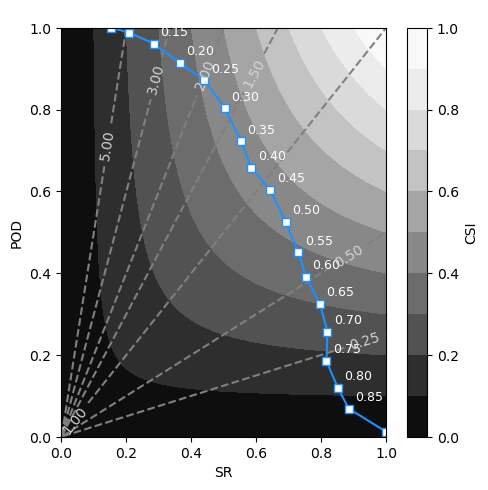

In [21]:
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(results_data['true'],results_data['pred'])
fps = fp(results_data['true'],results_data['pred'])
fns = fn(results_data['true'],results_data['pred'])

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)


#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,fontsize=9,color='white')

plt.tight_layout();

In [26]:
cutoff = .43
y_pred = np.where(results_data['pred']>cutoff,1,0)
true = np.array(results_data['true'])

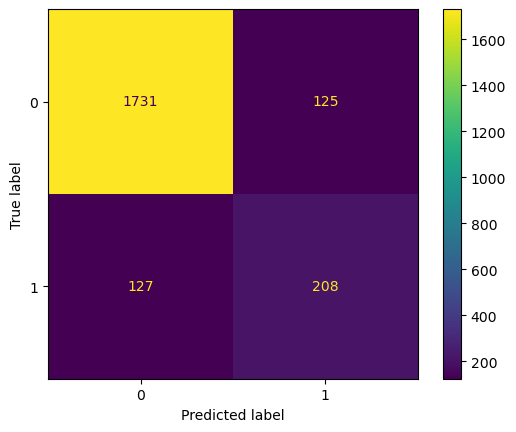

In [27]:

cm = confusion_matrix(true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

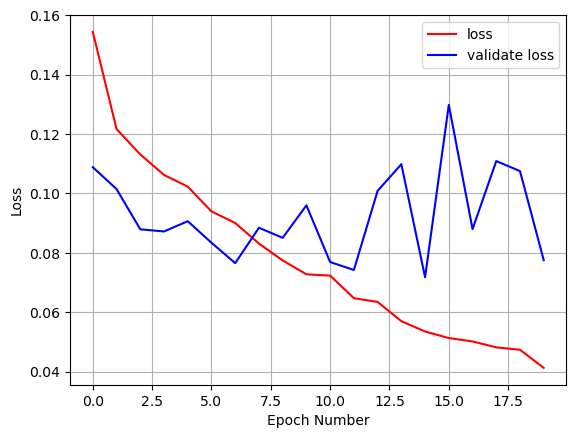

In [28]:
plt.plot(history.history['loss'],'-r', label = 'loss')
plt.plot(history.history['val_loss'],'-b', label = 'validate loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()

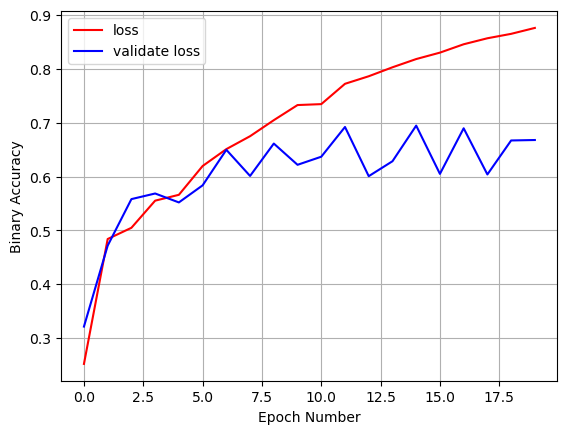

In [30]:
plt.plot(history.history['auc'],'-r', label = 'loss')
plt.plot(history.history['val_auc'],'-b', label = 'validate loss')
plt.xlabel('Epoch Number')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.grid()

In [31]:
for l,layer in enumerate(model.layers):
    print(l,layer.name)

0 input_1
1 input_2
2 input_3
3 SLP_lead0
4 H500_lead0
5 sf_lead0
6 model


In [68]:

[v_models[i].summary() for i in range(len(v_models))]

Model: "SLP_lead0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 17, 142, 50)       500       
                                                                 
 batch_normalization (BatchN  (None, 17, 142, 50)      200       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 17, 142, 50)       0         
                                                                 
 dropout (Dropout)           (None, 17, 142, 50)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 71, 50)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 69, 1)          45

[None, None, None]

In [78]:
# make sure layer[n] corresponds with layer you want to plot 

layer_variables =[tf.keras.models.Model([v_models[i].inputs], [v_models[i].layers[7].output]) for i in range(len(v_models))] 

layers_predict = [layer_variables[i].predict(val_X[i]) for i in range(len(v_models))]


69/69 [==============================] - 2s 26ms/step


In [79]:
AR_correct_id = np.argwhere((results_data.pred>.4) & (results_data.true==1)).squeeze()
noAR_correct_id = np.argwhere((results_data.pred<=.4) & (results_data.true==0)).squeeze()

In [80]:
correct_AR = [layers_predict[i][AR_correct_id].mean(axis = 0).squeeze() for i in range(len(v_models))] 
correct_noAR_SLP = [layers_predict[i][noAR_correct_id].mean(axis = 0).squeeze() for i in range(len(v_models))]

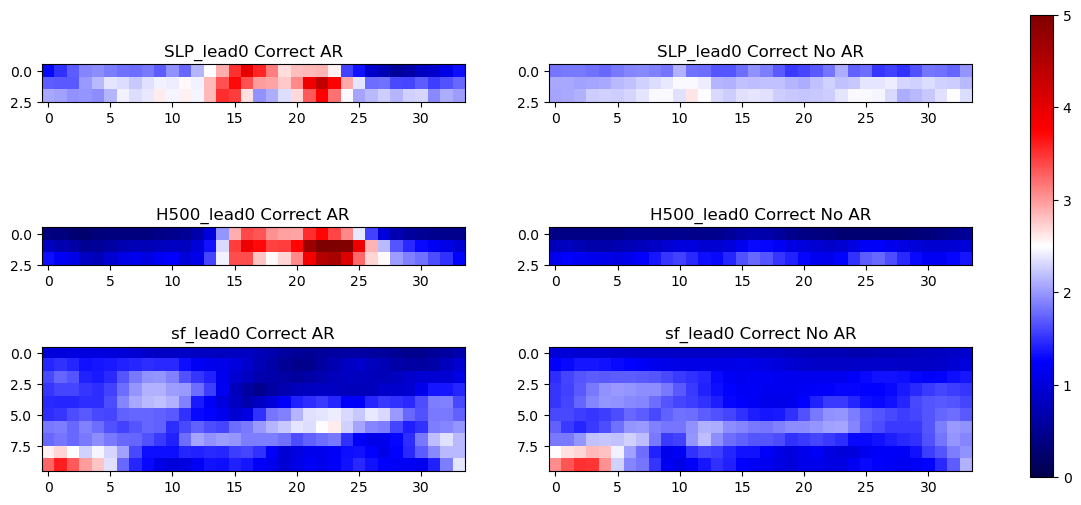

In [87]:

fig,axes = plt.subplots(len(correct_AR),2,figsize=(15,2*len(correct_AR)))

for n in range(len(correct_AR)):
    axes[n,0].imshow(correct_AR[n], vmin = 0, vmax = 5,cmap='seismic')
    cf = axes[n,1].imshow(correct_noAR_SLP[n], vmin = 0, vmax = 5,cmap='seismic')
    axes[n,0].set_title(v_models[n].name+' Correct AR')
    axes[n,1].set_title(v_models[n].name+' Correct No AR')


fig.colorbar(cf, ax = axes.ravel())
